In [11]:
## Importing important libraries
import yfinance as yf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


## Making the Momentum Strategy backtesting functions
class MomentumStrategy():


    ## Initialising the function
    def __init__(self, symbol, SMA, EMA, RSI, start, end):
        self.symbol = symbol
        self.SMA = SMA
        self.EMA = EMA
        self.RSI = RSI
        self.start = start
        self.end = end
        self.results = None
        self.get_data()

    
    def get_data(self):

        ## Downloading the stock data and converting the prices to Datafrane
        df = yf.download(self.symbol, start = self.start, end = self.end)
        data = df["Close"].to_frame()

        ## Calculating Gains and Losses for RSI Calculation
        data["Change"] = data["Close"] - data["Close"].shift(1)
        data["Gain"] = np.where(data["Change"] >= 0, data["Change"], 0)
        data["Loss"] = np.where(data["Change"] <= 0, data["Change"], 0)
        data["Av_Gain"] = data["Gain"].ewm(span=self.RSI, min_periods=self.RSI).mean()
        data["Av_Loss"] = data["Loss"].ewm(span=self.RSI, min_periods=self.RSI).mean()

        ## Calculating RSI (both versions)
        data["RSI1"] = (100 - ( 100 / (1+(data["Av_Gain"].div(abs(data["Av_Loss"]))))))
        data["RSI2"] = (100 - ( 100 / (1+((data["Av_Gain"].shift(1)*(self.RSI - 1) + data["Av_Gain"]) / (abs(data["Av_Loss"].shift(1)*(self.RSI - 1)) + data["Av_Loss"])))))
        
        ## Calculating the Simple and Exponential Moving Averages
        data["EMA"] = data["Close"].ewm(span=self.EMA, min_periods=self.EMA).mean()
        data["SMA"] = data["Close"].rolling(window=self.SMA, min_periods=self.SMA).mean()

        ## Storing filtered data for backtest
        data.dropna(inplace=True)
        self.data2 = data

        return data 

    
    def backtest(self):
        data = self.data2.copy().dropna()

        ## Calculating normal (Buy and Hold) returns
        data["Returns"] = np.log(data["Close"].div(data["Close"].shift(1))).cumsum()

        ## Strategy Logic - Buy when EMA goes over SMA, short when SMA goes over EMA
        data["Strategy"] = np.where(data["EMA"] >= data["SMA"], 1, -1)
        
        ## Take Profit Condition - Close long position when RSI>90 & short position when RSI<15
        stoplong = (data["Strategy"] == 1) & (data["RSI1"] >= 80) & (data["RSI2"] >= 80)
        stopshort = (data["Strategy"] == -1) & (data["RSI1"] <= 20) & (data["RSI2"] <= 20)
        data.loc[ stoplong | stopshort, "Strategy"] = 0


        ## Calculating our Strategy Returns
        data["ReturnsStrategy"] = (np.log(data["Close"].div(data["Close"].shift(1))) * data["Strategy"].shift(1)).cumsum()
        data.dropna(inplace=True)
        self.results = data
        self.data3 = data

        return data

    
    ## Backtesting Results
    def testresults(self):
        if self.results is None:
            print("Run Backtest through .backtest()")
        else:
            data = self.data3.copy().dropna()
            perf = data["ReturnsStrategy"].iloc[-1]
            outperf = perf - data["Returns"].iloc[-1]
            data[["Returns","ReturnsStrategy"]].plot(figsize=(16,12), fontsize=14, xlabel="Date", ylabel="Returns")
            plt.title("{} | EMA{} | SMA{} | RSI Period: {}".format(self.symbol, self.EMA, self.SMA, self.RSI), fontsize=24)
            plt.legend(fontsize=14)
            plt.show()

            return outperf 


    ## Strategy Graph
    def strategy(self):
        if self.results is None:
            print("Run Backtest through .backtest()")
        else:
            data = self.data3.copy().dropna()
            graphdata = data[["Close", "EMA", "SMA", "RSI1", "RSI2"]].copy()
            graph, axis = plt.subplots(2)
            axis[0].plot(graphdata[["Close", "EMA", "SMA"]])
            axis[0].set_title("Prices & Strategy")
            axis[0].legend(["Close", "EMA", "SMA"])
            axis[0].set_xlabel("Date")
            axis[0].set_ylabel("Price$")
            axis[1].plot(graphdata[["RSI1", "RSI2"]])
            axis[1].set_title("Relative Strength Index Indicator")
            axis[1].legend(["RSI1", "RSI2"])
            axis[1].set_xlabel("Date")
            axis[1].set_ylabel("RSI")
            graph.set_figheight(20)
            graph.set_figwidth(16)
            plt.legend(fontsize=14)
            plt.show


In [25]:
Test = MomentumStrategy("C", 26, 12, 14, "2014-01-01", "2024-01-01")
Test.backtest()

[*********************100%%**********************]  1 of 1 completed


,Close,Change,Gain,Loss,Av_Gain,Av_Loss,RSI1,RSI2,EMA,SMA,Returns,Strategy,ReturnsStrategy
Date,,,,,,,,,,,,,
2014-02-10,49.320000,-0.020000,0.000000,-0.020000,0.379870,-0.335077,53.132591,56.643080,48.798872,51.029231,-0.000405,-1,0.000405
2014-02-11,49.660000,0.340000,0.340000,0.000000,0.374456,-0.289573,56.391523,56.644138,48.932597,50.885385,0.006465,-1,-0.006465
2014-02-12,49.959999,0.299999,0.299999,0.000000,0.364369,-0.250344,59.274616,59.822297,49.091913,50.737308,0.012488,-1,-0.012488
2014-02-13,49.860001,-0.099998,0.000000,-0.099998,0.315113,-0.230021,57.804768,62.551770,49.210872,50.571154,0.010484,-1,-0.010484
2014-02-14,49.520000,-0.340000,0.000000,-0.340000,0.272595,-0.244860,52.679904,61.410977,49.258700,50.367693,0.003642,-1,-0.003642
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,50.860001,0.260002,0.260002,0.000000,0.430328,-0.179410,70.575913,71.705053,49.502392,47.565769,0.030342,1,-0.217185
2023-12-26,51.340000,0.480000,0.480000,0.000000,0.436951,-0.155488,73.754536,73.479235,49.785101,47.822308,0.039735,1,-0.207791
2023-12-27,51.459999,0.119999,0.119999,0.000000,0.394690,-0.134757,74.547672,76.303978,50.042777,48.056923,0.042070,1,-0.205457


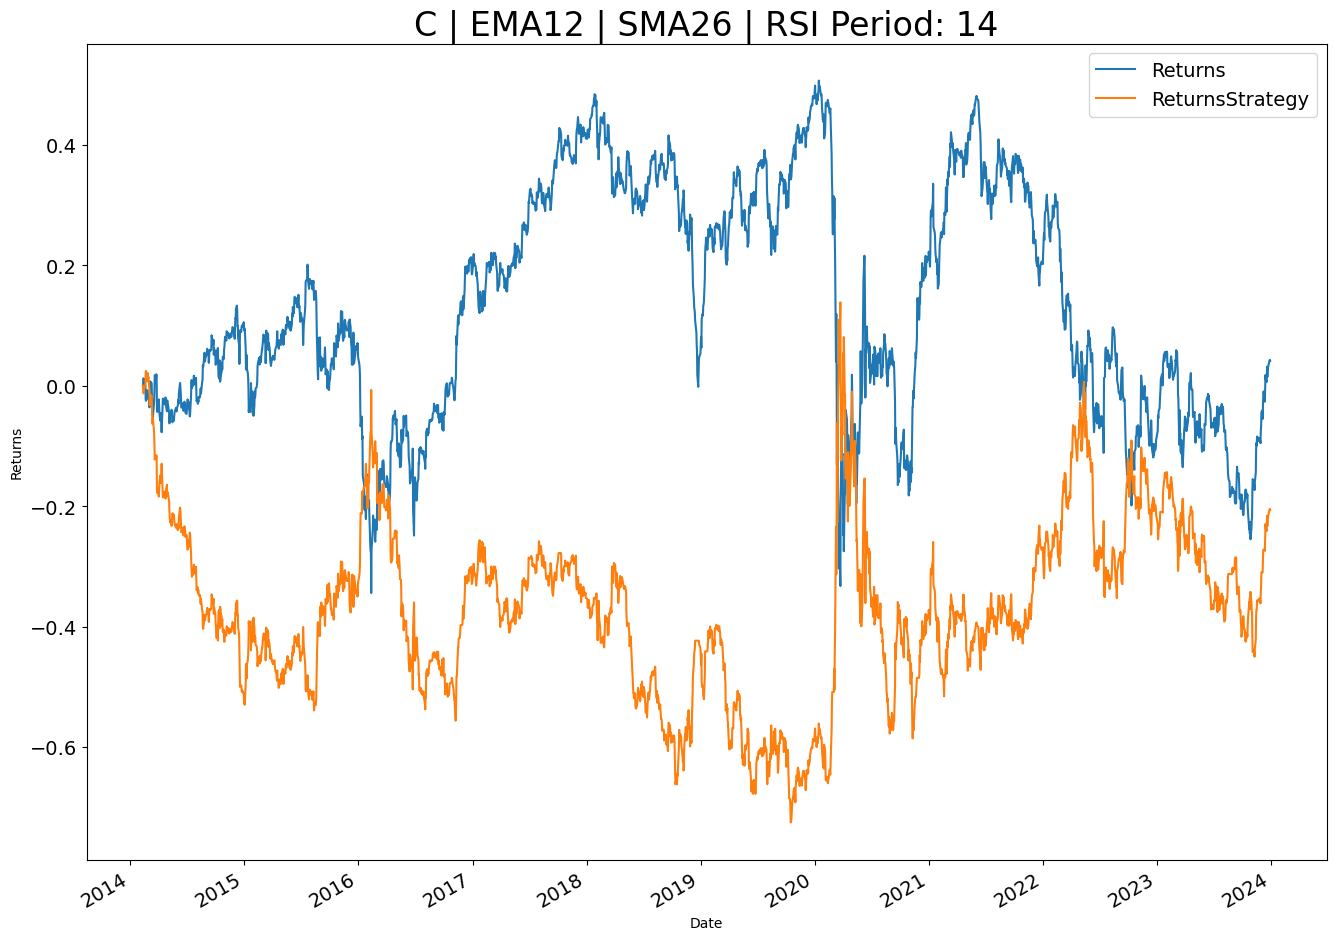

-0.2475262303762824

In [27]:
Test.testresults()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


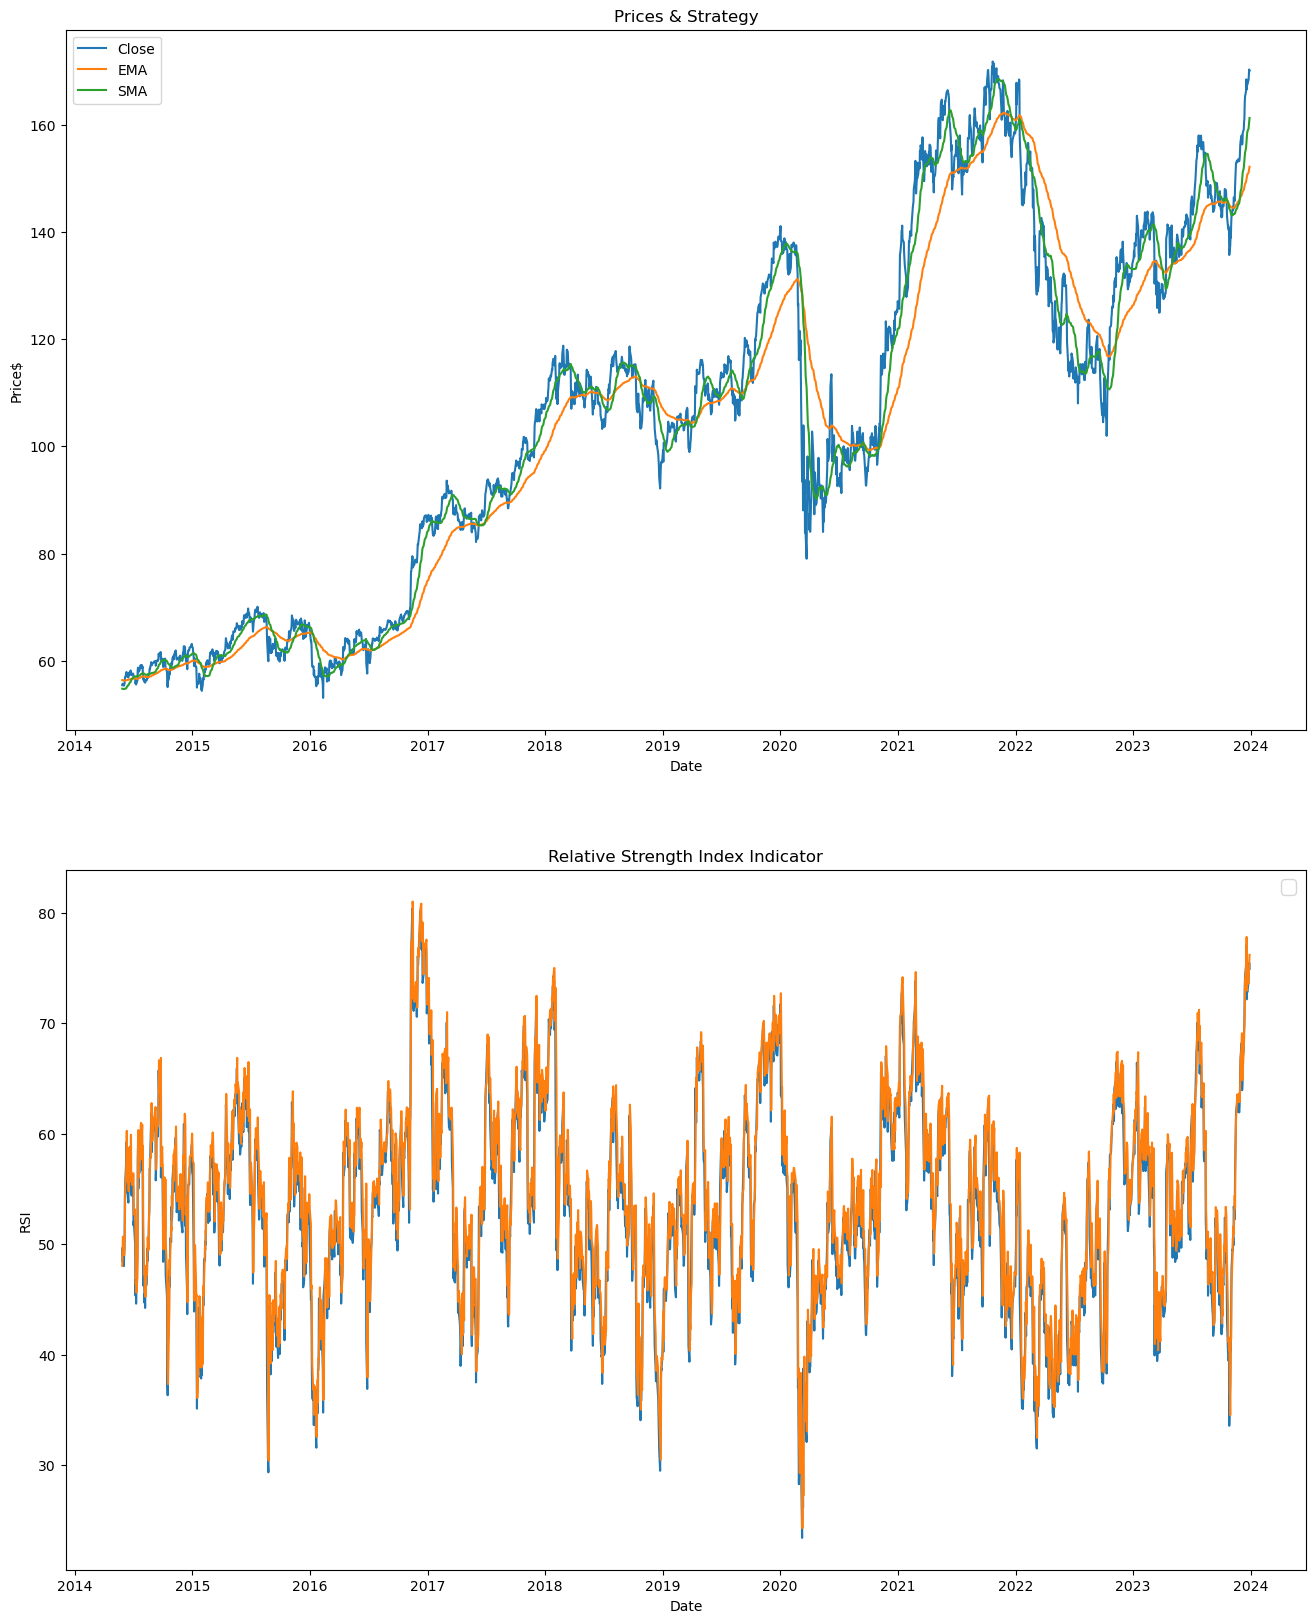

In [19]:
Test.strategy()